In [1]:
# Imports
import numpy as np
import numpy.linalg as nplin
import numpy.random as npran
import scipy as sp
import scipy.linalg as splin
import scipy.stats as spstat1gt
import matplotlib.pyplot as plt
import inspect
import requests
from __future__ import division
from multiprocessing import Pool

import glmnet
reload(glmnet)
import knockoffGLM as ko
reload(ko)       # as I update it
import simulate as sim
reload(sim)
import pandas as pd

# show pyplots in the notebook
%matplotlib inline

ImportError: No module named _glmnet

In [4]:
from compare import *
genes = np.genfromtxt('data/SNPdata.txt', delimiter=',')
np.place(genes,genes!=0,1)
X = given_X(100,1000,genes)

In [20]:
# failing that, backup seeds gotten by good ol copy and paste
with open('data/backup_seeds.txt','r') as f:
    seeds = [int(seed) for seed in f.read().split()]

In [ ]:
np.arange(10,20)[npran.permutation(10)]

In [10]:
# Load the genetic data
genes = np.genfromtxt('data/SNPdata.txt', delimiter=',')
# replace all the 2s with 1s
np.place(genes,genes!=0,1)

In [ ]:
import compare as comp

with open('data/backup_seeds.txt','r') as f:
    seeds = [int(seed) for seed in f.read().split()]

ns = [200,500,1000,1500,2000,3000,4000,5000,6500,8000,10000]
b = 50
ps = [10,20,30,40]
MCs = [10000,25000,50000,100000]
fit_data = np.load('data/sigma_fit.npy')
s_data   = np.load('data/sfit.npy')

def gen_logit(input):
    " Testing function, all parameters are in a single tuple """
    seed,n,p,MCsize = input
    npran.seed(seed)
    X = comp.ising_X(p,n)
    y = comp.bern_y(X,1)

    model = ko.knockoff_logit(y,X,.2,
                            knockoff='binary',
                            MCsize=MCsize,
                            fresh_sim=True,
                            intercept=True
                            ) 
    model._binary_knockoff()   
    return (model.M_distortion,np.mean([cor for cor in model.emp_ko_corr if not np.isnan(cor)]))

pool = Pool(processes=2)

for i in range(len(ps)):
    for j in range(len(ns)):
        params = zip(np.array(seeds)[npran.choice(len(seeds),b)],np.ones(b)*ns[j],np.ones(b)*ps[i],np.ones(b)*MCs[i])

        measures = pool.map(gen_logit,params)
        fit_data[i,j] = np.mean([m1 for (m1,m2) in measures])
        s_data[i,j] = np.mean([m2 for (m1,m2) in measures])
        with open('data/sigma_fit.npy','w') as f:
            np.save(f,fit_data)
        with open('data/sfit.npy','w') as f:
            np.save(f,s_data)
        print 'finished p=%d, n=%d' % (ps[i],ns[j])

pool.close()        
        
# Plot  
f,subplts = plt.subplots(2,1)
f.set_size_inches(4,4)

subplts[0].set_xlim(0,max(ns))
subplts[0].set_ylim(0,.25)
subplts[0].set_xlabel('Observations')
subplts[0].set_ylabel('Gram Distortion')
for i in range(len(ps)):
    subplts[0].plot(ns,fit_data[i,:],label='p=%d' % ps[i],marker='.')

subplts[1].set_xlim(0,max(ns))
subplts[1].set_ylim(0,1)
subplts[1].set_xlabel('Observations')
subplts[1].set_ylabel('Knockoff Correlation')
for i in range(len(ps)):
    subplts[1].plot(ns,s_data[i,:],label='p=%d' % ps[i],marker='.')

subplts[1].legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

plt.savefig('images/sigma_fit.pdf',bbox_inches='tight')      


finished p=10, n=200
finished p=10, n=500
finished p=10, n=1000
finished p=10, n=1500
finished p=10, n=2000
finished p=10, n=3000
finished p=10, n=4000
finished p=10, n=5000
finished p=10, n=6500
finished p=10, n=8000
finished p=10, n=10000
finished p=20, n=200Variable 8 fully relaxed
Variable 12 fully relaxed
Variable 16 fully relaxedVariable 10 fully relaxed

Variable 18 relaxed by tau=0.25Variable 14 fully relaxed

Variable 16 fully relaxedVariable 8 fully relaxed

Variable 12 fully relaxedVariable 19 fully relaxed

Variable 19 fully relaxedVariable 20 fully relaxed


finished p=20, n=500
finished p=20, n=1000
finished p=20, n=1500
finished p=20, n=2000
finished p=20, n=3000
finished p=20, n=4000
finished p=20, n=5000
finished p=20, n=6500
finished p=20, n=8000
finished p=20, n=10000
finished p=30, n=200Variable 14 fully relaxedVariable 26 fully relaxed

Variable 21 fully relaxedVariable 8 fully relaxed

Variable 22 fully relaxedVariable 22 fully relaxed

Variable 1 fully relaxedVar

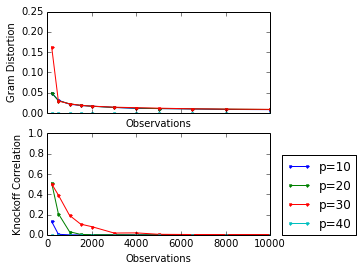

In [4]:
# Plot  
f,subplts = plt.subplots(2,1,sharex=True)
f.set_size_inches(4,4)

subplts[0].set_xlim(0,max(ns))
subplts[0].set_ylim(0,.25)
subplts[0].set_xlabel('Observations')
subplts[0].set_ylabel('Gram Distortion')
for i in range(len(ps)):
    subplts[0].plot(ns,fit_data[i,:],label='p=%d' % ps[i],marker='.')

subplts[1].set_xlim(0,max(ns))
subplts[1].set_ylim(0,1)
subplts[1].set_xlabel('Observations')
subplts[1].set_ylabel('Knockoff Correlation')
for i in range(len(ps)):
    subplts[1].plot(ns,s_data[i,:],label='p=%d' % ps[i],marker='.')

subplts[1].legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

plt.savefig('images/sigma_fit.pdf',bbox_inches='tight') 

### Compare performance with LASSO

In [2]:
lasso_data = pd.read_table('data/lasso_test_100.txt',
                           header=0,
                           names=['seed','gen','p1','dist','bin_ko_corr','bin_fdr','bin_power','ori_ko_corr','ori_fdr','ori_power','corr']
                          )

logit_data = pd.read_table('data/logit_test_100.txt',
                           header=0,
                           names=['seed','gen','p1','dist','ko_corr','fdr','power']
                          )



In [20]:
logit_data.groupby('p1').count()

,seed,gen,dist,ko_corr,fdr,power
p1,,,,,,
5,175,175,175,175,175,175
10,175,175,175,175,175,175
15,175,175,175,175,175,175
20,175,175,175,175,175,175
25,175,175,175,175,175,175


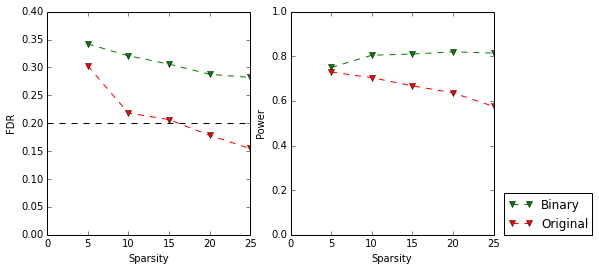

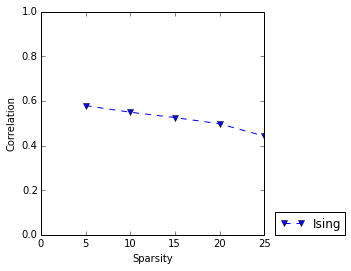

In [16]:
p1s = [5,10,15,20,25]
q = .2

lasso_data = pd.read_table('data/lasso_test_100.txt',
                           header=0,
                           names=['seed','gen','p1','dist','bin_ko_corr','bin_fdr','bin_power','ori_ko_corr','ori_fdr','ori_power','corr']
                          )

logit_data = pd.read_table('data/logit_test_100.txt',
                           header=0,
                           names=['seed','gen','p1','dist','ko_corr','fdr','power']
                          )


# FDR and Power
f,subplts = plt.subplots(1,2)
f.set_size_inches(8,4)

# FDR Plot
subplts[0].set_xlim(0,max(p1s))
subplts[0].set_ylim(0,q*2)
subplts[0].set_xlabel('Sparsity')
subplts[0].set_ylabel('FDR')
subplts[0].plot(p1s,lasso_data.groupby('p1').mean().bin_fdr,label="Binary", linestyle='--', marker='v', color='g')
subplts[0].plot(p1s,lasso_data.groupby('p1').mean().ori_fdr,label="Original", linestyle='--', marker='v', color='r')

subplts[0].plot((0,max(p1s)),(q,q),'k--')

# power plot
subplts[1].set_xlim(0,max(p1s))
subplts[1].set_ylim(0,1)
subplts[1].set_xlabel('Sparsity')
subplts[1].set_ylabel('Power')
subplts[1].plot(p1s,lasso_data.groupby('p1').mean().bin_power,label="Binary", linestyle='--', marker='v', color='g')
subplts[1].plot(p1s,lasso_data.groupby('p1').mean().ori_power,label="Original", linestyle='--', marker='v', color='r')


# Legend
subplts[1].legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

plt.savefig('images/lasso_FDR_power.pdf',bbox_inches='tight')      
     
# Correlation plot  
f,ax = plt.subplots(1)
f.set_size_inches(4,4)

ax.set_xlim(0,max(p1s))
ax.set_ylim(0,1)
ax.set_xlabel('Sparsity')
ax.set_ylabel('Correlation')
ax.plot(p1s,lasso_data.groupby('p1').mean()['corr'],linestyle='--', marker='v',label="Ising")
ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

subplts[1].legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

plt.savefig('images/lasso_corr.pdf',bbox_inches='tight')  

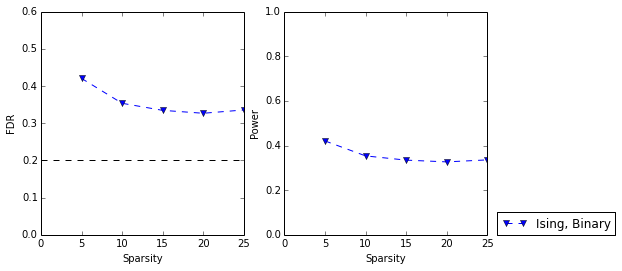

In [18]:
n = 1000
b = 100
p = 50
q = .2
p1s = [5,10,15,20,25]

# FDR and Power
f,subplts = plt.subplots(1,2)
f.set_size_inches(8,4)

# FDR Plot
subplts[0].set_xlim(0,max(p1s))
subplts[0].set_ylim(0,q*3)
subplts[0].set_xlabel('Sparsity')
subplts[0].set_ylabel('FDR')
subplts[0].plot(p1s,logit_data.groupby('p1').mean().fdr,label="Ising, Binary", linestyle='--', marker='v')
subplts[0].plot((0,max(p1s)),(q,q),'k--')

# power plot
subplts[1].set_xlim(0,max(p1s))
subplts[1].set_ylim(0,1)
subplts[1].set_xlabel('Sparsity')
subplts[1].set_ylabel('Power')
subplts[1].plot(p1s,logit_data.groupby('p1').mean().fdr,label="Ising, Binary", linestyle='--', marker='v')

# Legend
subplts[1].legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

plt.savefig('images/logit_FDR_power.pdf',bbox_inches='tight') 

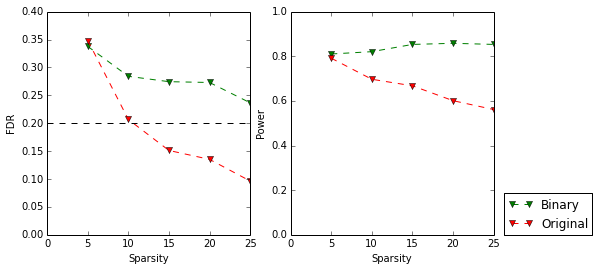

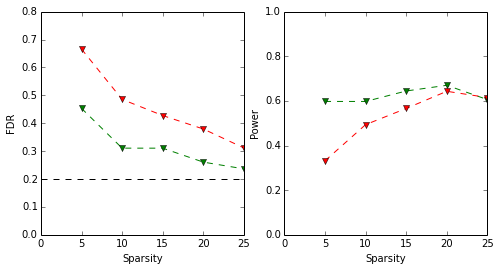

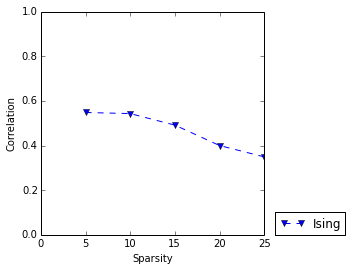

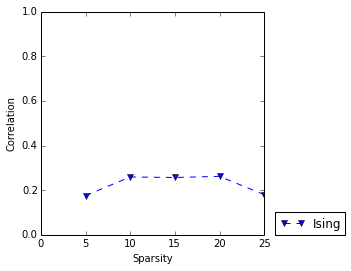

In [20]:
p1s = [5,10,15,20,25]
q = .2

lasso_data_50 = pd.read_table('data/lasso_test_50.txt',
                           header=0,
                           names=['seed','gen','p1','dist','bin_ko_corr','bin_fdr','bin_power','ori_ko_corr','ori_fdr','ori_power','corr']
                          )

logit_data_50 = pd.read_table('data/logit_test_50.txt',
                           header=0,
                           names=['seed','gen','p1','dist','bin_ko_corr','bin_fdr','bin_power','ori_ko_corr','ori_fdr','ori_power','corr']
                          )

# FDR and Power
f_las,subplts_las = plt.subplots(1,2)
f_log,subplts_log = plt.subplots(1,2)
f_las.set_size_inches(8,4)
f_log.set_size_inches(8,4)

# FDR Plot
subplts_las[0].set_xlim(0,max(p1s))
subplts_las[0].set_ylim(0,q*2)
subplts_las[0].set_xlabel('Sparsity')
subplts_las[0].set_ylabel('FDR')
subplts_las[0].plot(p1s,lasso_data_50.groupby('p1').mean().bin_fdr,label="Binary", linestyle='--', marker='v', color='g')
subplts_las[0].plot(p1s,lasso_data_50.groupby('p1').mean().ori_fdr,label="Original", linestyle='--', marker='v', color='r')

subplts_las[0].plot((0,max(p1s)),(q,q),'k--')

# power plot
subplts_las[1].set_xlim(0,max(p1s))
subplts_las[1].set_ylim(0,1)
subplts_las[1].set_xlabel('Sparsity')
subplts_las[1].set_ylabel('Power')
subplts_las[1].plot(p1s,lasso_data_50.groupby('p1').mean().bin_power,label="Binary", linestyle='--', marker='v', color='g')
subplts_las[1].plot(p1s,lasso_data_50.groupby('p1').mean().ori_power,label="Original", linestyle='--', marker='v', color='r')

# Legend
subplts_las[1].legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

plt.savefig('images/lasso_FDR_power_50.pdf',bbox_inches='tight')      

# FDR Plot
subplts_log[0].set_xlim(0,max(p1s))
subplts_log[0].set_ylim(0,q*4)
subplts_log[0].set_xlabel('Sparsity')
subplts_log[0].set_ylabel('FDR')
subplts_log[0].plot(p1s,logit_data_50.groupby('p1').mean().bin_fdr,label="Binary", linestyle='--', marker='v', color='g')
subplts_log[0].plot(p1s,logit_data_50.groupby('p1').mean().ori_fdr,label="Original", linestyle='--', marker='v', color='r')

subplts_log[0].plot((0,max(p1s)),(q,q),'k--')

# power plot
subplts_log[1].set_xlim(0,max(p1s))
subplts_log[1].set_ylim(0,1)
subplts_log[1].set_xlabel('Sparsity')
subplts_log[1].set_ylabel('Power')
subplts_log[1].plot(p1s,logit_data_50.groupby('p1').mean().bin_power,label="Binary", linestyle='--', marker='v', color='g')
subplts_log[1].plot(p1s,logit_data_50.groupby('p1').mean().ori_power,label="Original", linestyle='--', marker='v', color='r')


plt.savefig('images/logit_FDR_power_50.pdf',bbox_inches='tight')      

# Correlation plot  
f_las,ax_las = plt.subplots(1)
f_las.set_size_inches(4,4)

ax_las.set_xlim(0,max(p1s))
ax_las.set_ylim(0,1)
ax_las.set_xlabel('Sparsity')
ax_las.set_ylabel('Correlation')
ax_las.plot(p1s,lasso_data_50.groupby('p1').mean()['corr'],linestyle='--', marker='v',label="Ising")
ax_las.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

plt.savefig('images/logit_corr_50.pdf',bbox_inches='tight')  

# Correlation plot  
f_log,ax_log = plt.subplots(1)
f_log.set_size_inches(4,4)

ax_log.set_xlim(0,max(p1s))
ax_log.set_ylim(0,1)
ax_log.set_xlabel('Sparsity')
ax_log.set_ylabel('Correlation')
ax_log.plot(p1s,logit_data_50.groupby('p1').mean()['corr'],linestyle='--', marker='v',label="Ising")
ax_log.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

plt.savefig('images/logit_corr_50.pdf',bbox_inches='tight')  

In [14]:
logit_data_50.groupby('p1').count()

,seed,gen,dist,bin_ko_corr,bin_fdr,bin_power,ori_ko_corr,ori_fdr,ori_power,corr
p1,,,,,,,,,,
5,158,158,158,158,158,158,158,158,158,146
10,156,156,156,156,156,156,156,156,156,144
15,155,155,155,155,155,155,155,155,155,143
20,156,156,156,156,156,156,156,156,156,152
25,157,157,157,157,157,157,157,157,157,143


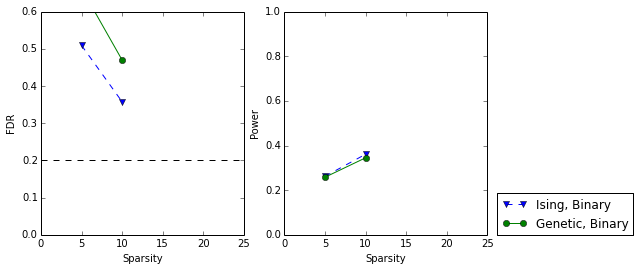

In [37]:
gen_data[:,2:]=np.nan
isl_data[:,2:]=np.nan

# FDR and Power
f,subplts = plt.subplots(1,2)
f.set_size_inches(8,4)

# FDR Plot
subplts[0].set_xlim(0,max(p1s))
subplts[0].set_ylim(0,q*3)
subplts[0].set_xlabel('Sparsity')
subplts[0].set_ylabel('FDR')
subplts[0].plot(p1s,isl_data[0,:],label="Ising, Binary", linestyle='--', marker='v')
subplts[0].plot(p1s,gen_data[0,:],label="Genetic, Binary", linestyle='-', marker='o')
subplts[0].plot((0,max(p1s)),(q,q),'k--')

# power plot
subplts[1].set_xlim(0,max(p1s))
subplts[1].set_ylim(0,1)
subplts[1].set_xlabel('Sparsity')
subplts[1].set_ylabel('Power')
subplts[1].plot(p1s,isl_data[1,:],label="Ising, Binary", linestyle='--', marker='v')
subplts[1].plot(p1s,gen_data[1,:],label="Genetic, Binary", linestyle='-', marker='o')

# Legend
subplts[1].legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

plt.savefig('images/logit_FDR_power.pdf',bbox_inches='tight') 

In [39]:
range(2,5)

[2, 3, 4]

In [2]:
str(5)+'1232'

'51232'

In [35]:
X,y = sim.genXy_given_X_norm_y(80,genes,1000,65,5)
s,v,d = nplin.svd(X)
min(v)

5.0674582231104308e-14

In [18]:
min(v)

1.2302364734335055e-14

In [36]:
.75**1000

1.151498540124827e-125

In [40]:
[i for i in range(10) if np.notnan(i)]

AttributeError: 'module' object has no attribute 'notnan'